<a href="https://colab.research.google.com/github/cakecalto/pcd-ann/blob/main/PCD_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset from Kaggle Datasets

In [1]:
!pip install kaggle
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
import pandas
 
od.download(
    "https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhamadluthfirey
Your Kaggle Key: ··········


100%|██████████| 161M/161M [00:00<00:00, 175MB/s]


Importing Images

In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32
CHANNELS = 3
EPOCHES= 100

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/corn-or-maize-leaf-disease-dataset/data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


## EDA

In [6]:
for images, labels in dataset:
    # Print the shape of the images and labels
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break  # Stop after the first batch

Images shape: (32, 256, 256, 3)
Labels shape: (32,)


In [7]:
import os
import glob as gb
path = "//content//corn-or-maize-leaf-disease-dataset//data"
size=[]
for folder in os.listdir(path):
    files = gb.glob(pathname=str(path+"//"+folder+"/*.jpg"))
    for file in files:
        image=plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(256, 256, 3)      1323
(768, 1024, 3)        8
(2448, 3264, 3)       7
(1200, 675, 3)        7
(350, 750, 3)         5
                   ... 
(3000, 4000, 3)       1
(293, 220, 3)         1
(335, 662, 3)         1
(500, 500, 3)         1
(329, 432, 3)         1
Length: 265, dtype: int64

In [8]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [9]:
len(dataset)

131

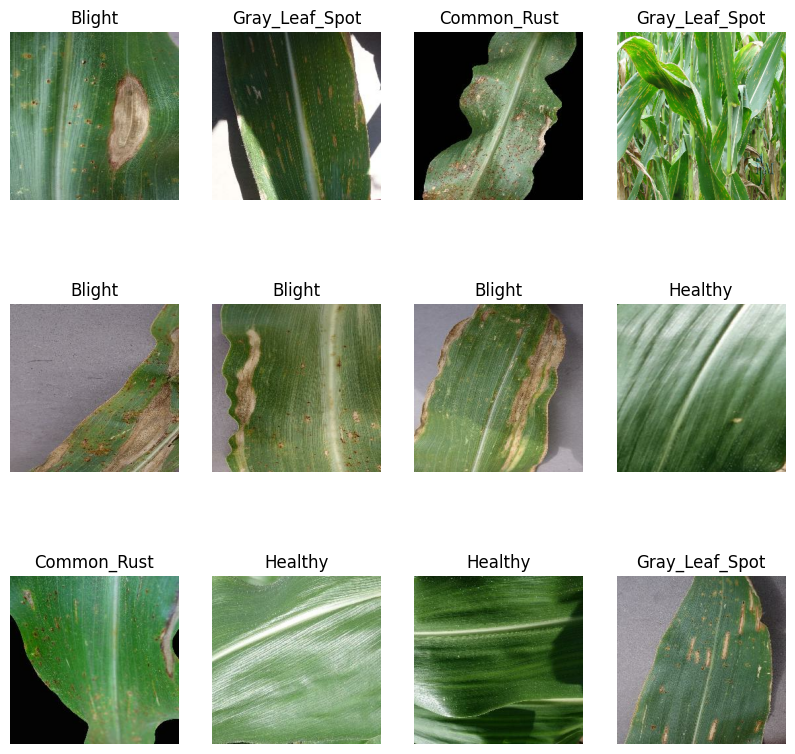

In [10]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# Pre-processing

Split dataset

In [11]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [12]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [13]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 104

Length of Validation Dataset is 13

Length of Testing Dataset is 14


In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Reshape & Rescaling

In [15]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3),
])

# Model Building

In [17]:
n_classes = 4
input_shape = (BATCH_SIZE,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'), 
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 flatten (Flatten)           (32, 196608)              0         
                                                                 
 dense (Dense)               (32, 256)                 50331904  
                                                                 
 dense_1 (Dense)             (32, 128)                 32896     
                                                                 
 dense_2 (Dense)             (32, 64)                  8256      
                                                                 
 dense_3 (Dense)             (32, 32)                 

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
)

In [20]:
history = model.fit(
  train_ds,
  epochs=25,
  batch_size=BATCH_SIZE,
  verbose=1,
  validation_data=val_ds
)

Epoch 1/25
104/104 [==============================] - 25s 106ms/step - loss: 8.9691 - accuracy: 0.5078 - val_loss: 2.5065 - val_accuracy: 0.6490
Epoch 2/25
104/104 [==============================] - 3s 24ms/step - loss: 2.0746 - accuracy: 0.6453 - val_loss: 3.2295 - val_accuracy: 0.6154
Epoch 3/25
104/104 [==============================] - 3s 24ms/step - loss: 1.7963 - accuracy: 0.6456 - val_loss: 1.4414 - val_accuracy: 0.6418
Epoch 4/25
104/104 [==============================] - 3s 24ms/step - loss: 1.2681 - accuracy: 0.6793 - val_loss: 0.6726 - val_accuracy: 0.7740
Epoch 5/25
104/104 [==============================] - 3s 26ms/step - loss: 0.7578 - accuracy: 0.7202 - val_loss: 0.6505 - val_accuracy: 0.7284
Epoch 6/25
104/104 [==============================] - 3s 26ms/step - loss: 0.7814 - accuracy: 0.7295 - val_loss: 0.5787 - val_accuracy: 0.7740
Epoch 7/25
104/104 [==============================] - 3s 25ms/step - loss: 0.6584 - accuracy: 0.7431 - val_loss: 0.5829 - val_accuracy: 0.76

Save current model to GDrive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Save the model
model_filename = "pcd_model_ann_2.h5"
path = f"drive/My Drive/PCD-MODEL/Model/{model_filename}" 
model.save(path)
print("Model saved as", model_filename)

Model saved as pcd_model_ann_2.h5


Load Model

In [20]:
from tensorflow.keras.models import load_model

# Load the saved model
model_filename = "drive/My Drive/PCD-MODEL/Model/pcd_model_ann_2.h5"
loaded_model = load_model(model_filename)
print("Model loaded from", model_filename)

Model loaded from drive/My Drive/PCD-MODEL/Model/pcd_model_ann_2.h5


Evaluate the model

In [21]:
scores = loaded_model.evaluate(test_ds)

14/14 [==============================] - 12s 14ms/step - loss: 0.4822 - accuracy: 0.8147
